In [ ]:
# okk

In [ ]:
!pip install -q kaggle

In [ ]:

from google.colab import files
files.upload()  # This will prompt you to upload the kaggle.json file


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aroojzahra","key":"a872123416faa088384afea314a1ee79"}'}

In [ ]:
# create a kaggle directory

!mkdir ~/.kaggle


In [ ]:
# copy the kaggle.json to created the folder
!cp kaggle.json ~/.kaggle/

In [ ]:
# permission for the json to act
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# to list all the datasets in kaggle
!kaggle datasets list

ref                                                              title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
hanaksoy/customer-purchasing-behaviors                           Customer Purchasing Behaviors                         1KB  2024-09-01 22:18:07           2377         32  1.0              
haseebindata/student-performance-predictions                     Student Performance Predictions                       9KB  2024-08-17 06:57:57          10429        226  0.9411765        
lainguyn123/student-performance-factors                          Student Performance Factors                          94KB  2024-09-02 10:53:57           3521         82  1.0              
abdullah0a/retail-sales-data-with-seasonal-trends-and-m

In [ ]:
!kaggle datasets download -d mohit3430/haze1k


Dataset URL: https://www.kaggle.com/datasets/mohit3430/haze1k
License(s): unknown
100% 952M/953M [00:56<00:00, 20.4MB/s]
100% 953M/953M [00:56<00:00, 17.6MB/s]


In [ ]:
!unzip haze1k.zip -d ./haze1k


Archive:  haze1k.zip
  inflating: ./haze1k/Distributed_haze1k/test_moderate/input/001.png  
  inflating: ./haze1k/Distributed_haze1k/test_moderate/input/002.png  
  inflating: ./haze1k/Distributed_haze1k/test_moderate/input/003.png  
  inflating: ./haze1k/Distributed_haze1k/test_moderate/input/004.png  
  inflating: ./haze1k/Distributed_haze1k/test_moderate/input/005.png  
  inflating: ./haze1k/Distributed_haze1k/test_moderate/input/006.png  
  inflating: ./haze1k/Distributed_haze1k/test_moderate/input/007.png  
  inflating: ./haze1k/Distributed_haze1k/test_moderate/input/008.png  
  inflating: ./haze1k/Distributed_haze1k/test_moderate/input/009.png  
  inflating: ./haze1k/Distributed_haze1k/test_moderate/input/010.png  
  inflating: ./haze1k/Distributed_haze1k/test_moderate/input/011.png  
  inflating: ./haze1k/Distributed_haze1k/test_moderate/input/012.png  
  inflating: ./haze1k/Distributed_haze1k/test_moderate/input/013.png  
  inflating: ./haze1k/Distributed_haze1k/test_moderate/i

In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np

# Define constants
IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 32
EPOCHS = 50

# Load and preprocess images
def load_and_preprocess_image(file_path):
    img = Image.open(file_path).resize((IMG_WIDTH, IMG_HEIGHT))
    img = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
    return img

hazy_imgs = []
clear_imgs = []

# Load input hazy images
for file in os.listdir('/content/haze1k/Distributed_haze1k/train/input'):
    img = load_and_preprocess_image(os.path.join('/content/haze1k/Distributed_haze1k/train/input', file))
    hazy_imgs.append(img)

# Load target clear images
for file in os.listdir('/content/haze1k/Distributed_haze1k/train/target'):
    img = load_and_preprocess_image(os.path.join('/content/haze1k/Distributed_haze1k/train/target', file))
    clear_imgs.append(img)

# Convert to numpy arrays
hazy_imgs = np.array(hazy_imgs, dtype=np.float32)
clear_imgs = np.array(clear_imgs, dtype=np.float32)

# Split data into training and validation sets
train_hazy, val_hazy, train_clear, val_clear = train_test_split(hazy_imgs, clear_imgs, test_size=0.2, random_state=42)

# Define CNN model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

# Define a U-Net like architecture
def build_unet(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)):
    inputs = Input(input_shape)

    # Downsampling path
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)

    # Upsampling path
    up1 = UpSampling2D((2, 2))(conv3)
    concat1 = concatenate([up1, conv2])  # Skip connection
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat1)

    up2 = UpSampling2D((2, 2))(conv4)
    concat2 = concatenate([up2, conv1])  # Skip connection
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(concat2)

    outputs = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(conv5)

    model = keras.Model(inputs, outputs)
    return model

# Build and compile the U-Net model
model = build_unet()
model.compile(optimizer='adam', loss='mean_squared_error')


# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
history = model.fit(train_hazy, train_clear, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(val_hazy, val_clear))

# Evaluate model
mse = model.evaluate(val_hazy, val_clear)
print(f'MSE: {mse:.2f}')

# Use model for haze removal
def remove_haze(hazy_img):
    hazy_img = hazy_img / 255.0  # Normalize the image before prediction
    hazy_img = np.expand_dims(hazy_img, axis=0)  # Add batch dimension
    clear_img = model.predict(hazy_img)
    clear_img = clear_img[0] * 255.0  # Remove batch dimension and denormalize
    clear_img = clear_img.astype(np.uint8)
    return clear_img


Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - loss: 0.0393 - val_loss: 0.0371
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 299ms/step - loss: 0.0349 - val_loss: 0.0266
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 307ms/step - loss: 0.0269 - val_loss: 0.0265
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 305ms/step - loss: 0.0244 - val_loss: 0.0211
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 303ms/step - loss: 0.0201 - val_loss: 0.0176
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 306ms/step - loss: 0.0171 - val_loss: 0.0193
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 318ms/step - loss: 0.0171 - val_loss: 0.0194
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 308ms/step - loss: 0.0151 - val_loss: 0.0149
Epoch 9/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 304ms/step - loss: 0.0141 - val_loss: 0.0181
Epoch 10/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 301ms/step - loss: 0.0156 - val_loss: 0.0178
Epoch 11/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 300ms/step - loss: 0.0161 - val_loss: 0.0147
Epoch 12/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 30

In [ ]:
# Save the trained model to a file
model.save('haze_removal_model.h5')


In [ ]:
# Load the saved model
loaded_model = keras.models.load_model('/content/haze_removal_model.h5')


In [63]:
from PIL import Image
import numpy as np

# Load the single image you want to test
def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((IMG_WIDTH, IMG_HEIGHT))  # Resize the image
    img = np.array(img) / 255.0  # Normalize the pixel values
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Path to the hazy image you want to remove haze from
test_image_path = '/content/haze1k/Distributed_haze1k/test_thin/input/001.png'

# Preprocess the test image
hazy_image = preprocess_image(test_image_path)

# Predict the clear image using the loaded model
clear_image = loaded_model.predict(hazy_image)

# Post-process the predicted image
clear_image = clear_image[0] * 255.0  # Remove batch dimension and denormalize
clear_image = clear_image.astype(np.uint8)

# Save the predicted image
output_image = Image.fromarray(clear_image)
output_image.save('clear_image_result.jpg')

print("Haze removed and image saved as 'clear_image_result.jpg'")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Haze removed and image saved as 'clear_image_result.jpg'


In [58]:
import os
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

# Define the path to your datasets
PATH = '/content/haze1k/Distributed_haze1k/'

# Load the saved model
loaded_model = keras.models.load_model('/content/haze_removal_model.h5')

IMG_WIDTH = 256
IMG_HEIGHT = 256

def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((IMG_WIDTH, IMG_HEIGHT))  # Resize the image
    img = np.array(img) / 255.0  # Normalize the pixel values
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

def process_dataset(dataset_path):
    hazy_images = []  # Create a list to store the hazy images
    clear_images = []  # Create a list to store the processed clear images
    filenames = []  # To store filenames for display

    for filename in os.listdir(dataset_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):  # Check image file extensions
            image_path = os.path.join(dataset_path, filename)

            # Preprocess the image
            hazy_image = preprocess_image(image_path)
            hazy_image_display = np.squeeze(hazy_image, axis=0)  # Remove batch dimension for display
            hazy_images.append(hazy_image_display)
            filenames.append(filename)

            # Predict the clear image using the loaded model
            clear_image = loaded_model.predict(hazy_image)
            clear_image = clear_image[0] * 255.0  # Remove batch dimension and denormalize
            clear_image = clear_image.astype(np.uint8)
            clear_images.append(clear_image)

    return hazy_images, clear_images, filenames  # Return the list of hazy images, clear images, and filenames

# Load datasets
moderate_test_ds, moderate_clear_ds, moderate_filenames = process_dataset(PATH + 'test_moderate/input/')
thick_test_ds, thick_clear_ds, thick_filenames = process_dataset(PATH + 'test_thick/input/')
thin_test_ds, thin_clear_ds, thin_filenames = process_dataset(PATH + 'test_thin/input/')

def evaluate_test(hazy_images, clear_images, filenames, title, num_samples=3):
    fig, axs = plt.subplots(num_samples, 2, figsize=(10, num_samples * 5))

    selected_indices = np.random.choice(len(hazy_images), num_samples, replace=False)  # Randomly select indices

    for i, idx in enumerate(selected_indices):
        hazy_img = hazy_images[idx]
        clear_img = clear_images[idx]

        axs[i, 0].imshow(hazy_img)
        axs[i, 0].set_title(f'Hazy Image {filenames[idx]}')
        axs[i, 0].axis('off')

        axs[i, 1].imshow(clear_img)
        axs[i, 1].set_title(f'Predicted Clear Image {filenames[idx]}')
        axs[i, 1].axis('off')

    plt.suptitle(title, fontsize=20)
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━

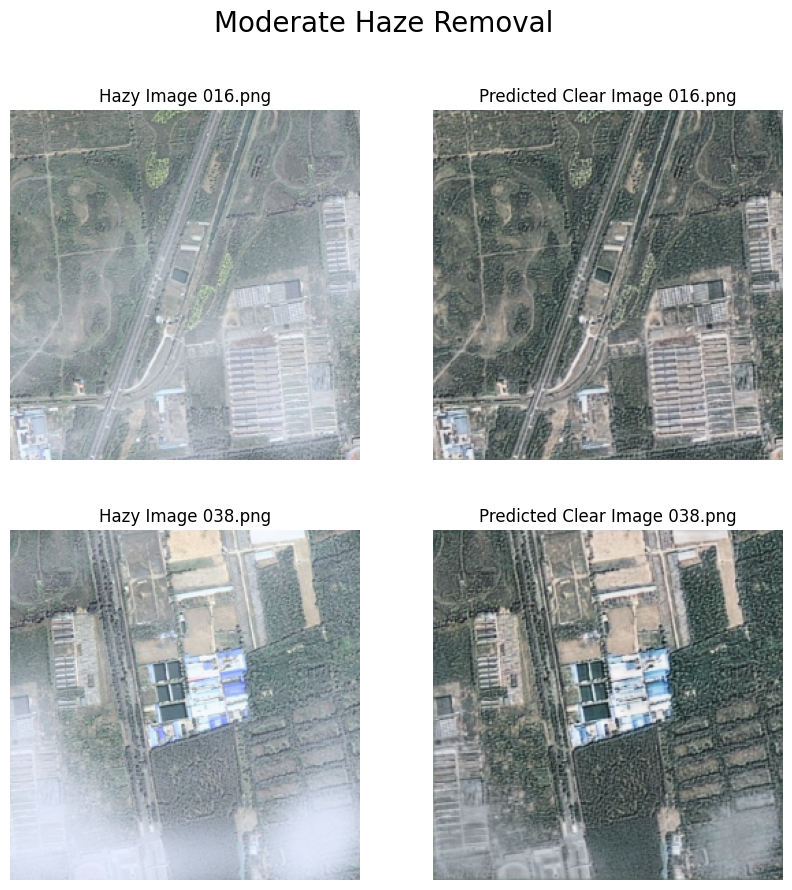

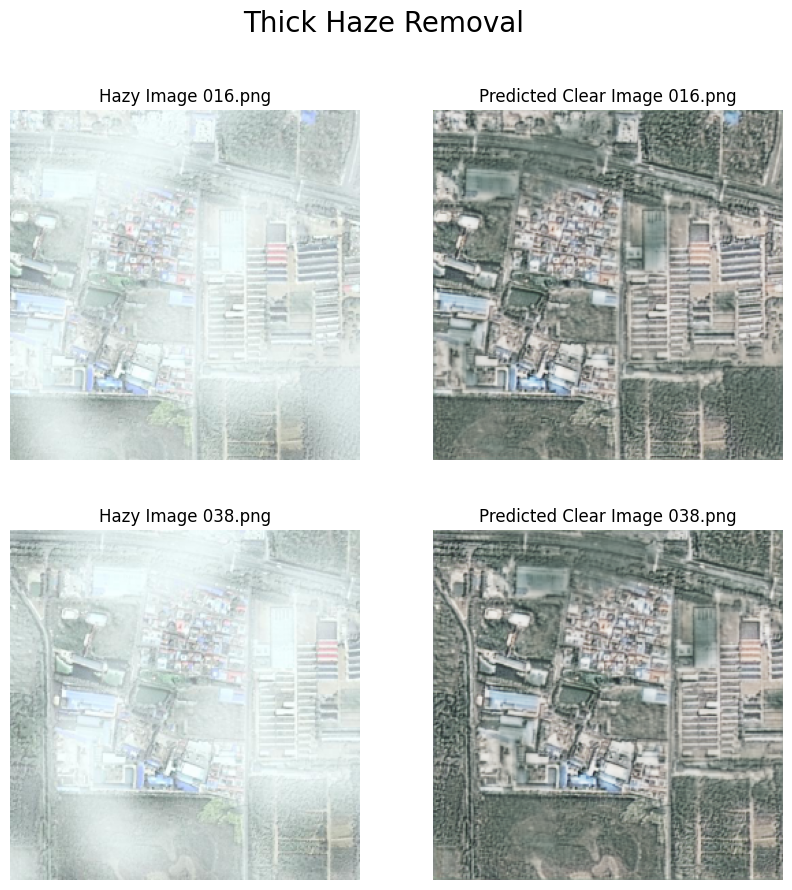

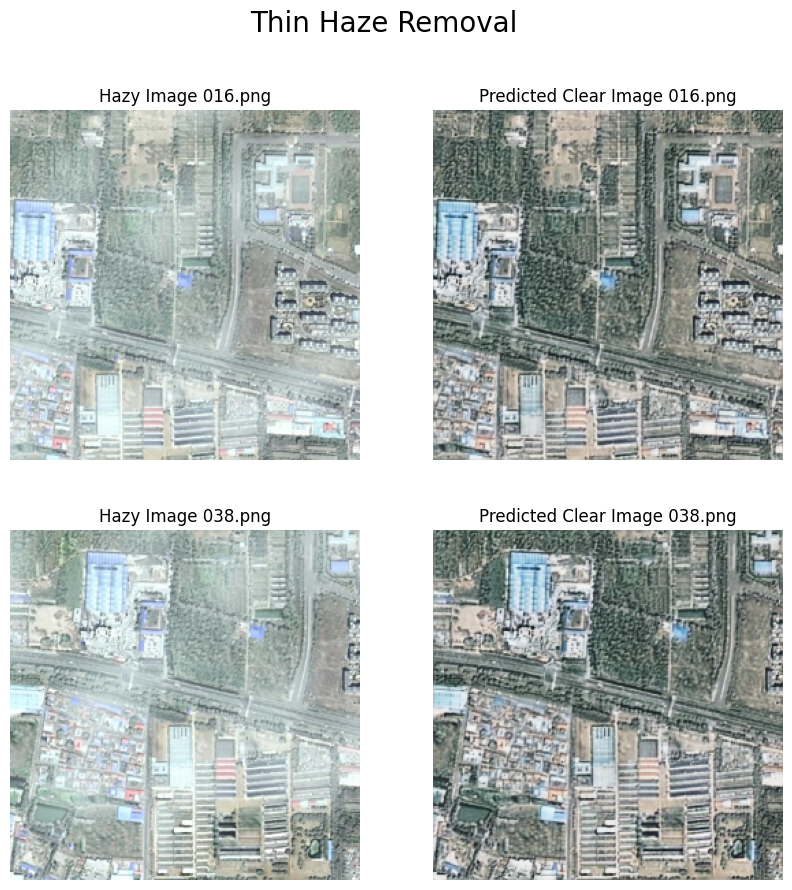

In [64]:
#Visualize results for each dataset
evaluate_test(moderate_test_ds, moderate_clear_ds, moderate_filenames, 'Moderate Haze Removal')
evaluate_test(thick_test_ds, thick_clear_ds, thick_filenames, 'Thick Haze Removal')
evaluate_test(thin_test_ds, thin_clear_ds, thin_filenames, 'Thin Haze Removal')
